<a href="https://colab.research.google.com/github/maryamhgf/LLM-Mastery/blob/master/SentimentAnalysis_AmazonReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Packages**

In [1]:
!pip install kaggle

import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Download Amazon Reviews Dataset**

In [3]:
!mkdir -p ~/.kaggle
!kaggle datasets download -d kritanjalijain/amazon-reviews
!unzip -o amazon-reviews.zip -d amazon-reviews

Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
License(s): CC0-1.0
100% 1.29G/1.29G [01:12<00:00, 18.3MB/s]
100% 1.29G/1.29G [01:12<00:00, 19.1MB/s]
Archive:  amazon-reviews.zip
  inflating: amazon-reviews/amazon_review_polarity_csv.tgz  
  inflating: amazon-reviews/test.csv  
  inflating: amazon-reviews/train.csv  


In [4]:
data = pd.read_csv('/content/amazon-reviews/train.csv', encoding='ISO-8859-1', header=None)
data_test = pd.read_csv('/content/amazon-reviews/test.csv', encoding='ISO-8859-1', header=None)
column_names = ['target', 'title', 'review']
data.columns = column_names
data_test.columns = column_names

# **Preprocess Data**

In [5]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def preprocess_data(data):
  data = data.dropna()
  data['text'] = data['review'] + ' ' + data['title']
  data['text'] = data['text'].apply(clean_text)
  return data

In [6]:
data = preprocess_data(data)
data_test = preprocess_data(data_test)

<ipython-input-5-2e3f361ab2f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['review'] + ' ' + data['title']
<ipython-input-5-2e3f361ab2f1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(clean_text)
<ipython-input-5-2e3f361ab2f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

# **Visualize Data**

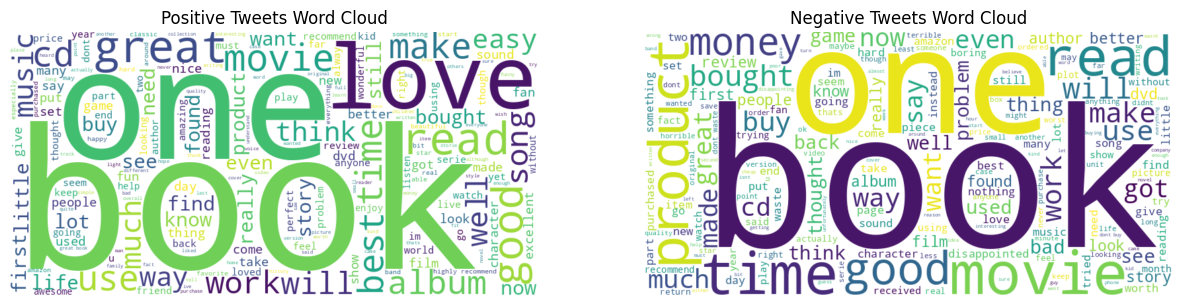

In [ ]:
positive_reviews = data[data['target'] == 2]['text']
negative_reviews = data[data['target'] == 1]['text']

sample_positive_text = " ".join(text for text in positive_reviews.sample(frac=0.1, random_state=23))
sample_negative_text = " ".join(text for text in negative_reviews.sample(frac=0.1, random_state=23))

wordcloud_positive = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(sample_positive_text)
wordcloud_negative = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(sample_negative_text)

plt.figure(figsize=(15, 7.5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis("off")

plt.show()

# **Sample Dataset (for experiments)**

In [10]:
sample_size_per_class = 30000

positive_sample = data[data['target'] == 2].sample(n=sample_size_per_class, random_state=23)
negative_sample = data[data['target'] == 1].sample(n=sample_size_per_class, random_state=23)

balanced_sample = pd.concat([positive_sample, negative_sample])

balanced_sample['target'].value_counts()

,count
target,
2,30000
1,30000


In [11]:
data = balanced_sample

#**Split Dataset**

In [12]:
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2, random_state=23)

# **Vectorization**

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train).todense()
X_val_vectorized = vectorizer.transform(X_val).todense()

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

base_model = DecisionTreeClassifier(random_state=42)

model = BaggingClassifier(base_model, n_estimators=50, random_state=42)

model.fit(np.asarray(X_train_vectorized), y_train)

y_pred = model.predict(np.asarray(X_val_vectorized))

accuracy = accuracy_score(y_val, y_pred)
print(f'Bagging Accuracy: {accuracy * 100:.2f}%')

# **Using Distilbert**

In [13]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

sentiment_classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

X_val_list = X_val.tolist()

predicted = sentiment_classifier(X_val_list, batch_size=16)

predicted_labels = [result['label'] for result in predicted]

predicted_series = pd.Series(predicted_labels, index=X_val.index)

print(predicted_series)

unique_values = predicted_series.unique()
print("Unique values before mapping:", unique_values)

520138     POSITIVE
98384      NEGATIVE
952293     NEGATIVE
3167655    POSITIVE
2516661    NEGATIVE
             ...   
1343069    NEGATIVE
877051     NEGATIVE
593654     POSITIVE
1266424    POSITIVE
2708953    NEGATIVE
Length: 12000, dtype: object
Unique values before mapping: ['POSITIVE' 'NEGATIVE']


In [16]:
sentiment_map = {'NEGATIVE': 1, 'POSITIVE': 2}
predicted_mapped = predicted_series.map(sentiment_map)

In [17]:
accuracy = accuracy_score(y_val, predicted_mapped)

f1 = f1_score(y_val, predicted_mapped, average='binary')

precision = precision_score(y_val, predicted_mapped, average='binary')

recall = recall_score(y_val, predicted_mapped, average='binary')

tn, fp, fn, tp = confusion_matrix(y_val, predicted_mapped).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"Specificity: {specificity}")

Accuracy: 0.8734166666666666
F1 Score: 0.8823301572546286
Precision: 0.8244064852345108
Recall (Sensitivity): 0.9490084985835694
Specificity: 0.9490084985835694


# **Finetuning Model**

In [ ]:
#tba